# MiniEP 7
**Diogo José Costa Alves (13709881)**

In [66]:
cpu_info()

CPU(s):                          4
Model name:                      Intel(R) Core(TM) i5-3570 CPU @ 3.40GHz
Thread(s) per core:              1
Core(s) per socket:              4


# Faça testes variando o tamanho do vetor, a quantidade de threads e a quantidade de ifs encadeados, mostrando médias e intervalos de confiança dos tempos impressos na saída. Você pode utilizar gráficos, imagens e/ou tabelas para apresentar os resultados obtidos.

**Resposta:**

O seguinte experimento foi executado para explorar os parâmetros: tamanho do vetor, quantidade de threads e  quantidade de ifs encadeados.

As seguintes combinações foram testadas:

- number_ifs: (0, 1, 32, 10000)

- array_sizes: (32752, 1048576, 10000000)

- number_threads: (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 8192, 32752)

Para estimar o invervalo de confiança das amostras foi utilizado o Teorema do Limite Central .
O Teorema do Limite Central afirma que, se você obtivermos um quantidade de amostras suficientemente grande de qualquer população, a distribuição das médias amostrais será aproximadamente uma distriuição normal. 
Observação: Quando não conhecemos a distribuição de origem, o **suficientemente grande** significa $n\ge30$. Caso a população de origem seja distribuida como uma normal, esse valor pode ser menor do que 30.

A partir dessa amostragem conseguimos realizar as seguinte inferências:

1. A distribuição das amostras será aproximadamente uma distribuição normal.

2. A distribuição das amostras tem uma média aproximadamente igual à média da população de origem.

3. A distribuição das amostras tem uma variância aproximadamente a variância da população de origem dividida pelo tamanho da amostra.

4. A distribuição das amostras tem um desvio padrão próximo ao desvio padrão da população de origem dividido pela raiz do tamanho da amostra.

Para o experiemento, cada combinação de parâmetros foi avaliada 30 vezes ($n=30$). No total, foram colhidos os tempos de 5.040 execuções. Esses resultados foram salvos no arquivo: minipe7_diogo_alves_results_raw.csv.

Por fim, para cada combinação de parâmetros, foi calculada a média ($\mu$), desvio padrão ($\sigma$) e e intervalo de confiança de 95% ($\mu - \frac{1.96*\sigma}{\sqrt{n}}, \mu + \frac{1.96*\sigma}{\sqrt{n} }$) e salvo no arquivo minipe7_diogo_alves_results_summary.csv.

As Figuras abaixo, resumem os resultados de todas execuções.

- O eixo x representa o número de threads.
- O eixo y representa o tempo de execução médio.
- As amostras (data points) estão destacadas com pontos vermelhos ('o') e representam os parâmetros testados.
- As linhas representam a interpolação das amostras coletadas.
- As áreas sombreadas representam o intevalo de confiança de 95%.
- O estilo da linha representa o número de IFs encadeados.

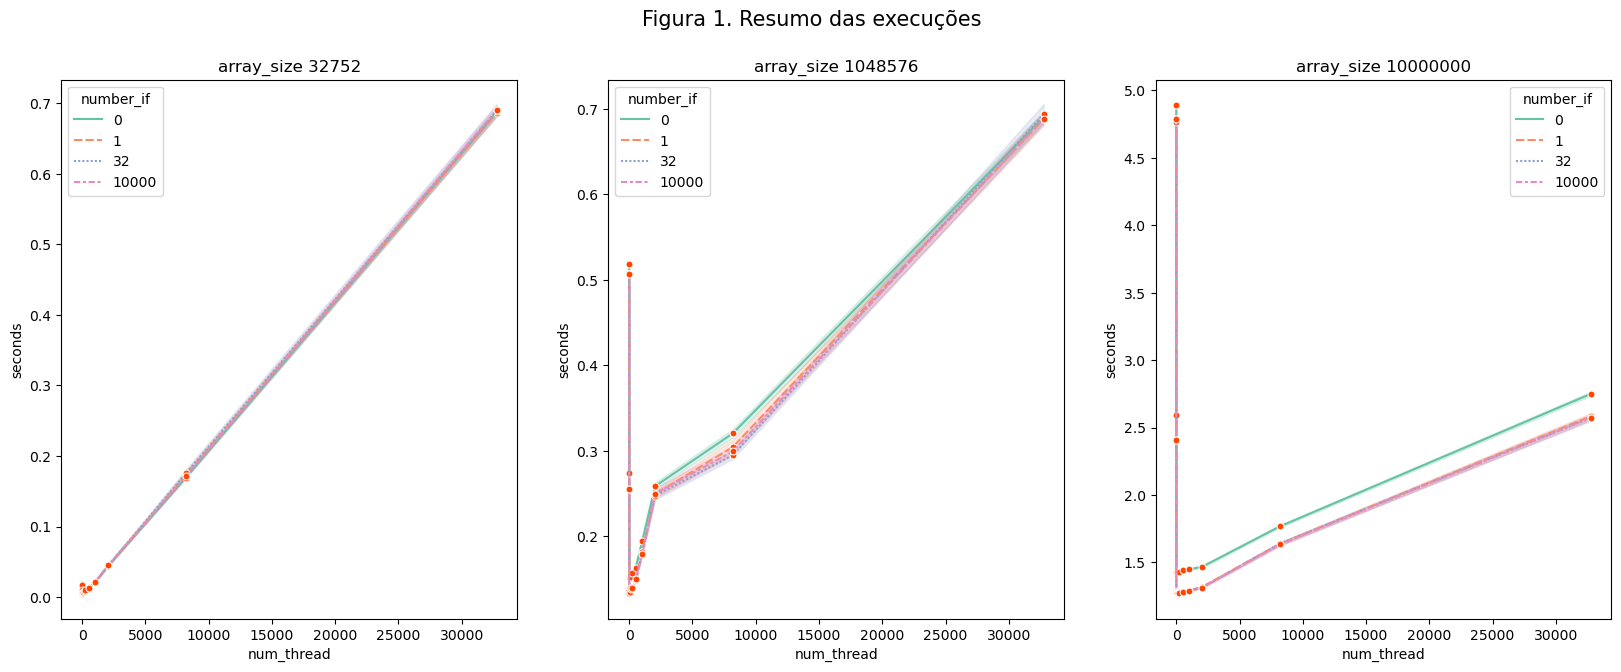

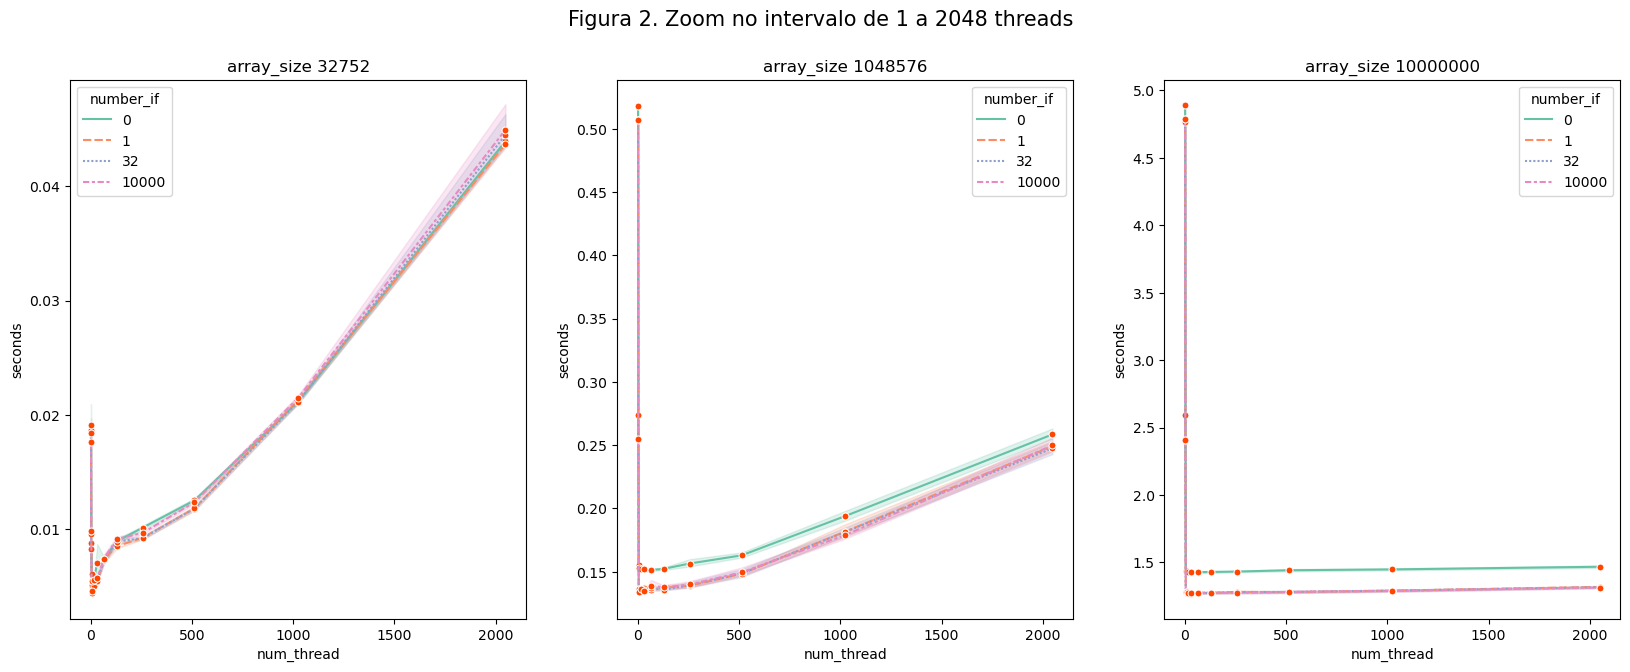

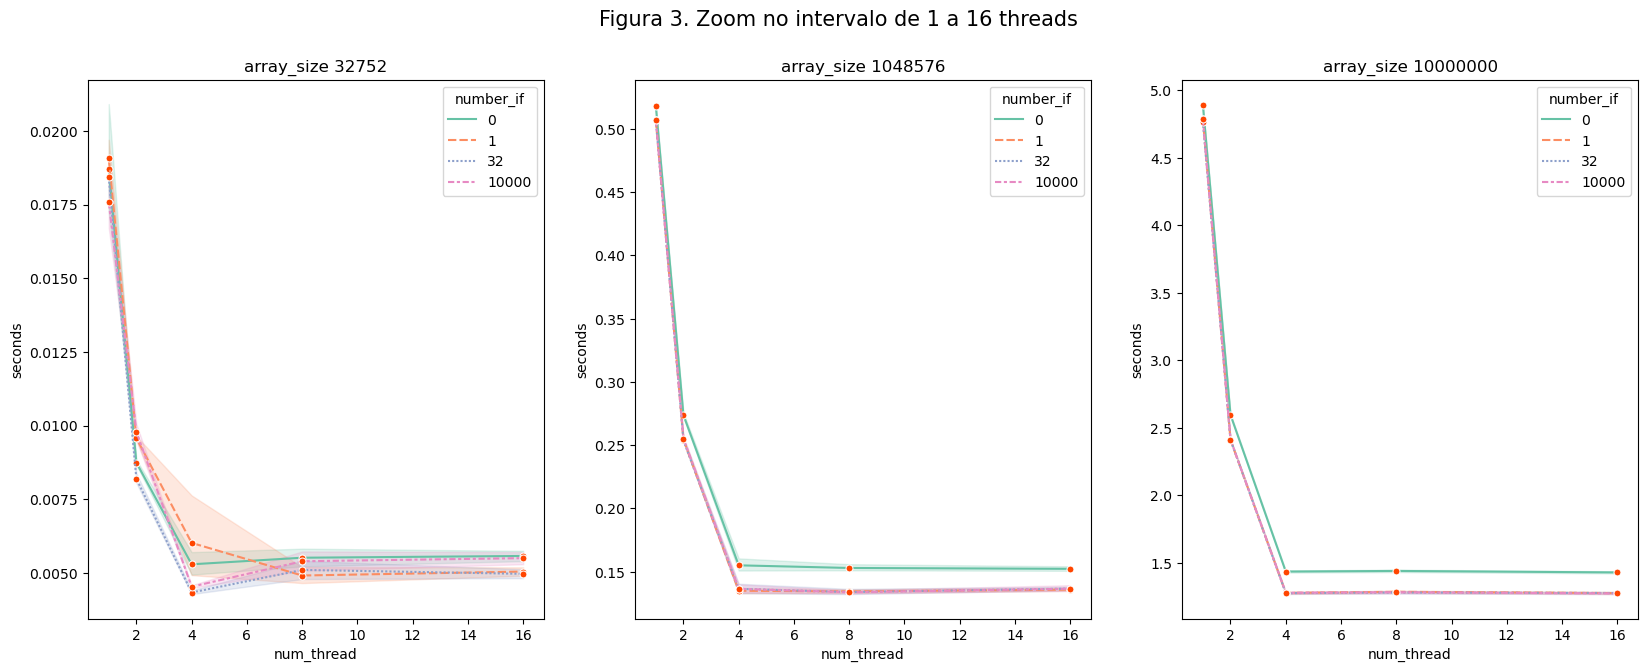

In [104]:
figuras()

# Explique os resultados observados nos testes do item anterior. Por que você acha que ocorreu o observado?

**Resposta:**

Na Figura 1, é possível perceber que o tempo de execução cai drasticamente no início. Permanece baixo por algumas amostras e logo em seguida existe uma tendência geral de crescimento no tempo de execução a medida que o número de threads aumenta. 

Acredito que este crescimento está relacionado à contenção explicada no enunciado do miniEP. Em outras palavras, o overhead causado pela criação e sincronia das threads concorre com o trabalho que deve ser realizado. 

Ainda na Figura 1, analisando os pontos iniciais e finais para os tamanhos de vetores menores (32.752 e 1.048.576), é possível perceber que o tempo de execução média nos pontos finais (32752 threads) supera ao tempo de execução média para o ponto inicial (uma única thread). Já quando tratamos o vetor de tamanho 10.000.000, o tempo de execução média com o maior número de threads parece convergir para uma speed up de quase 2x em relação ao tempo execução médio com uma única thread.

Na Figura 2, também é possível perceber que o ínicio da contenção está relacionado ao tamanho do vetor. Para vetores menores o overhead da criação e sincronia das threads é percebido antes.

A escala do gráfico da Figura 1, dificulta a análise do impacto do encadeamento de IFs. Já as Figuras 2 e 3, indicam  que a existencia de ifs encadeados reduzem o tempo de execução. Não parece fazer diferença significativa se forem incluídos 1 ou 10.000 ifs encadeados na parte de fora da seção crítica. Essa redução vem do fato que a instrução IF fora da seção crítica poupa, algumas vezes, o overhead do mutex.

A falta de visibilidade sobre o código gerado do compilador em conjunto com aparente falta de diferença significativa entre os testes com 1 ou 10.000 IFs encadeados levantam o questionamento se o compilador estaria ou não incluindo todos esse IFs no código de máquina. Essa questão desaparece ao perceber que na Figura 3, para o tamanho de vetor 32.752, no caso com uma única thread, o tempo médio de execução para 10.000 IFs encadeados é superior aos outros casos, sugerindo que o compilador está realmente  gerando código com os 10.000 IFs.



# Explique por que não podemos eliminar o if de dentro da seção crítica quando adicionamos o if de fora.

**Resposta:**

Os IFs da parte externa à região crítica, não são suficientes para garantir que durante a instrução de atribuição do valor, o novo valor local já não seja inferior o valor da memória compartilhada.

Portando, o IF de interno não pode ser eliminado, porque ele é necessário para garantir que dentro de região crítica, o valor da memória compartilhada não será sobrescrito com um resultado inferior.



----
# Anexos

## Código do experimento

In [99]:
import numpy as np
import pandas as pd
import subprocess
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from os.path import exists

CSV_RAW_FILE = 'miniep7_diogo_alves_results_raw.csv'
CSV_SUMMARY_FILE = 'miniep7_diogo_alves_results_summary.csv'

def cpu_info(): 
  command = "lscpu | grep -Ei '^Cpu\(s\):|thread|core'"
  subprocess.Popen(command, shell=True).wait()
  return None

def make(number_of_IFs=0):
  command = 'cd src/ && make'
  if number_of_IFs > 0: 
    command += f' IF={int(number_of_IFs)}'
  subprocess.Popen(command, shell=True, stdout=subprocess.DEVNULL).wait()
  return None

def contention(num_threads, array_size):
  timeout_s = 100  # in seconds
  cmd = ['./src/contention', str(num_threads), str(array_size)]
  try:
    result = subprocess.run(cmd, shell=False, capture_output=True, timeout=timeout_s, universal_newlines=True)
    return float(result.stdout.replace('s\n', ''))
  except subprocess.TimeoutExpired as e:
    return float(100)

def add_95perc_confidence(row):
  interval = (1.96 * row['std'])/row['count']
  row['95_confidence_interval_min'] = row['mean'] - interval
  row['95_confidence_interval_max'] = row['mean'] + interval
  return row

def experiment():
  samples_per_evaluation = 30 # magic number of central limit theorem

  array_sizes = (32752, 1048576, 10000000)
  number_threads = (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 8192, 32752)
  number_ifs = (0, 1, 32, 10000)
  
  results = []

  total_evaluations = samples_per_evaluation * len(array_sizes) * len(number_threads) * len(number_ifs)

  print(f'''
      number_ifs: {number_ifs}
      array_sizes: {array_sizes}
      number_threads: {number_threads}
      total_evaluations: {total_evaluations} ''')

  with tqdm(total=total_evaluations) as pbar:
    for number_if in number_ifs:
      make(number_of_IFs=number_if)
      for array_size in array_sizes:
        for num_thread in number_threads:
          for _ in range(samples_per_evaluation):
            seconds = contention(num_thread, array_size)
            results.append({'number_if': number_if, 'array_size': array_size, 'num_thread': num_thread, 'seconds': seconds} )
            pbar.update(1)


  results = pd.DataFrame(results)

  results_summary = results.groupby(['number_if', 'array_size', 'num_thread'])['seconds'].describe()[['count', 'mean', 'std']].reset_index()
  results_summary = results_summary.apply(add_95perc_confidence, axis=1)
  results_summary = results_summary.astype({'number_if': int, 'array_size': int, 'num_thread': int, 'count': int})
  
  results.to_csv(CSV_RAW_FILE, index=False)
  results_summary.to_csv(CSV_SUMMARY_FILE, index=False)

  return (results, results_summary)


def reload_or_run(force_reload=False):
  results_found = exists(CSV_RAW_FILE) and exists(CSV_SUMMARY_FILE)
  if results_found or force_reload:
    print('Results found. Loading data to workspace...')
    results = pd.read_csv(CSV_RAW_FILE)
    results_summary = pd.read_csv(CSV_SUMMARY_FILE)
  else:
    print('Results NOT found. Starting the experiment...')
    results, results_summary = experiment()
  return (results, results_summary)

results, results_summary = reload_or_run()
print('Data ready!')
# experiment()





Results NOT found. Starting the experiment...

      number_ifs: (0, 1, 32, 10000)
      array_sizes: (32752, 1048576, 10000000)
      number_threads: (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 8192, 32752)
      total_evaluations: 5040 


  0%|          | 0/5040 [00:00<?, ?it/s]

Data ready!


## Código gerador das figuras

In [103]:
def figura_1():
  fig, ax = plt.subplots(1,3,figsize=(20,7))
  fig.suptitle("Figura 1. Resumo das execuções", fontsize=15)
  index = 0
  for array_size in results['array_size'].unique():
    filtrado = results.loc[results['array_size'] == array_size]
    ax[index].title.set_text(f'array_size {array_size}')
    sns.lineplot(data=filtrado, x='num_thread', y='seconds', hue='number_if', style='number_if', marker='o', markerfacecolor='orangered', markersize=5, palette = "Set2", ax=ax[index])
    index += 1

def figura_2():
  fig, ax = plt.subplots(1,3,figsize=(20,7))
  limite_threads = 2048
  fig.suptitle(f"Figura 2. Zoom no intervalo de 1 a {limite_threads} threads", fontsize=15)
  index = 0
  for array_size in results['array_size'].unique():
    ax[index].title.set_text(f'array_size {array_size}')
    filtrado = results.loc[(results['array_size']== array_size) & (results['num_thread']<= limite_threads)]
    sns.lineplot(data=filtrado, x='num_thread', y='seconds', hue='number_if', style='number_if', marker='o', markerfacecolor='orangered', markersize=5, palette = "Set2", ax=ax[index])
    index += 1

def figura_3():
  fig, ax = plt.subplots(1,3,figsize=(20,7))
  limite_threads = 16
  fig.suptitle(f"Figura 3. Zoom no intervalo de 1 a {limite_threads} threads", fontsize=15)
  index = 0
  for array_size in results['array_size'].unique():
    ax[index].title.set_text(f'array_size {array_size}')
    filtrado = results.loc[(results['array_size']== array_size) & (results['num_thread']<= limite_threads)]
    sns.lineplot(data=filtrado, x='num_thread', y='seconds', hue='number_if', style='number_if', marker='o', markerfacecolor='orangered', markersize=5, palette = "Set2", ax=ax[index])
    index += 1

def figuras():
  figura_1()
  figura_2()
  figura_3()